In [1]:
#Loading packages
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import string
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import sqlite3
from sqlalchemy import create_engine
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import joblib

import warnings
warnings.filterwarnings('ignore')

We will start our analysis by importing our dataset from postgresql

In [2]:
#Information from PostgreSQL
host = r'localhost' 
db = r'MSDS610' 
user = r'postgres' 
pw = r'82328' 
port = r'5432' 
schema = r'RawData' 

In [3]:
#Creating a connection
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [4]:
#Listing the tables
sql="select tables.table_name from information_schema.tables where (table_schema ='"+schema+"')order by 1;"
tbl_df = pd.read_sql(sql, db_conn, index_col=None)
tbl_df

,table_name
0,listings


In [5]:
#Table name
table_name= r'listings'

In [6]:
#Verifying SQL database
sql=f'SELECT * FROM "{schema}"."{table_name}"'
df = pd.read_sql(sql, db_conn, index_col=None)

To start our cleaning, we will create a copy of our dataframe.

In [7]:
#Creating df_listings
df_listings = df.copy()

In [8]:
#Checking the data
df_listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2384,"Hyde Park - Walk to UChicago, 10 min to McCormick",2613,Rebecca,None,Hyde Park,41.78790,-87.58780,Private room,60,2,178,2019-12-15,2.56,1,353
1,4505,394 Great Reviews. 127 y/o House. 40 yds to tr...,5775,Craig & Kathleen,None,South Lawndale,41.85495,-87.69696,Entire home/apt,105,2,395,2020-07-14,2.81,1,155
2,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,None,West Town,41.90289,-87.68182,Entire home/apt,60,2,384,2020-03-08,2.81,1,321
3,9811,Barbara's Hideaway - Old Town,33004,At Home Inn,None,Lincoln Park,41.91769,-87.63788,Entire home/apt,65,4,49,2019-10-23,0.63,9,300
4,10610,3 Comforts of Cooperative Living,2140,Lois,None,Hyde Park,41.79612,-87.59261,Private room,21,1,44,2020-02-14,0.61,5,168


In [9]:
#Ensuring the shape of our dataset
df_listings.shape

(6297, 16)

## Part 3 - Data Definition and Analytical Question

### Data definition

- ID: This column is a unique identifier. The data type is numerical and discrete.
- Name: This column describes the Airbnb name, which is considered categorical.
- Host_ID: This column is a unique identifier for the host. The data is numerical and discrete.
- Host_Name: This column contains the name of the host; it is considered categorical.
- Neighbourhood:  This column represents the neighborhood where the Airbnb is located. It is categorical
- Neihghbourhood_group_cleansed: This is a column representing a higher-level category of neighborhoods. It is categorical.
- Latitude: This column is continuous and is a geographical coordinate that can take any value within a range.
- Longitude: This column is continuous, and like 'Latitude', it is a geographical coordinate.
- Room_type: This column is categorical and represents the room type, such as a private room or a shared room.
- Price: This is presented as a numeric value, the amount the user will pay to stay at Airbnb; the data is a continuous variable.
- Minimum nights: This column represents the minimum number of nights a guest must book. It is a discrete variable.
- Number of reviews: This column represents the number of reviews a listing has received. It is a discrete variable.
- Last_review: This column represents the date the last review was made. The column is continuous.
- Reviews per month: This column represents the number of reviews per month. It has numerical and continuous values.
- Calculated_hosts_listings_count: This column represents the number of listings per host.This column has numerical and continuous variables.
- Availability 365: This represents the number of available days a property can be booked in the year. It is a numerical and discrete variable.

### Analytical question

The selected dataset is titled "listings" and represents Chicago Airbnb Listings. Our goal is to understand the factors that influence Airbnb pricing, which will provide valuable insights to help us make an informed decision about wheter to invest on a property. Knowing this, our analytical question is: 

What are the key factors that significantly influence the pricing of Airbnb listings in Chicago?

## Part 4 – Data Prep and Feature Selection

### 'Clean' table

To begin our analysis, we will create a table outlining the steps for cleaning the live dataset. This will help us ensure that we address any data issues later in the live data analysis.

In [10]:
# Create a DataFrame (table)
data = {
    'Field_name': ['id', 'name', 'host_id', 'neighbourhood_group', 'last_review', 'reviews_per_month', 'price', 'neighbourhood', 'room_type', 'price_per_year', 'distance_to_city_center'],
    'Manipulation_type': ['Drop', 'Drop', 'Drop', 'Drop', 'Drop', 'NaN_replace', 'Outliers', 'Drop', 'encoded','new_feature', 'new_feature'],
    'Numeric_values': [np.nan, np.nan, np.nan, np.nan, np.nan, 0, (0,465), np.nan, np.nan, np.nan, np.nan]
}



# Create a pandas DataFrame (table)
clean_data_table = pd.DataFrame(data)

clean_data_table

,Field_name,Manipulation_type,Numeric_values
0,id,Drop,NaN
1,name,Drop,NaN
2,host_id,Drop,NaN
3,neighbourhood_group,Drop,NaN
4,last_review,Drop,NaN
5,reviews_per_month,NaN_replace,0
6,price,Outliers,"(0, 465)"
7,neighbourhood,Drop,NaN
8,room_type,encoded,NaN
9,price_per_year,new_feature,NaN


The table will be saved in an SQL schema named "cleaned". 

In [11]:
#Import clean_table to the database
table_name = r'clean_data_table'
schema = r'cleaned' 

clean_data_table.to_sql('clean_data_table', con=db_conn, index=False, if_exists='replace', schema=schema, chunksize=1000, method='multi')

11

<img align="left" style="padding-right:15px;" src="clean_data_table-screenshot.png" width=350><br>

### Missing values

We will begin our data cleaning process by calculating the percentage of missing values for each column in the dataset. This will guide us in determining the most appropriate method for handling the missing data. 

In [12]:
#Calculating the percentage of missing values
missing = df_listings.isnull().sum().sort_values(ascending=False)/len(df_listings)*100
missing

neighbourhood_group               100.000000
last_review                        17.706845
reviews_per_month                  17.706845
id                                  0.000000
name                                0.000000
host_id                             0.000000
host_name                           0.000000
neighbourhood                       0.000000
latitude                            0.000000
longitude                           0.000000
room_type                           0.000000
price                               0.000000
minimum_nights                      0.000000
number_of_reviews                   0.000000
calculated_host_listings_count      0.000000
availability_365                    0.000000
dtype: float64

The neighbourhood_group column has a 100% missing values, so it will be dropped from the dataset. Additionally, since the last_review, host_name, and name columns are not relevant to our analysis, we have decided to remove these as well. Helping us focus on the necessary data for our analysis. 

In [13]:
#Dropping columns
df_listings = df_listings.drop(columns=['neighbourhood_group', 'last_review', 'host_name', 'name', 'host_id', 'id'])
df_listings.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Hyde Park,41.78790,-87.58780,Private room,60,2,178,2.56,1,353
1,South Lawndale,41.85495,-87.69696,Entire home/apt,105,2,395,2.81,1,155
2,West Town,41.90289,-87.68182,Entire home/apt,60,2,384,2.81,1,321
3,Lincoln Park,41.91769,-87.63788,Entire home/apt,65,4,49,0.63,9,300
4,Hyde Park,41.79612,-87.59261,Private room,21,1,44,0.61,5,168


For the 17% of missing values in the reviews_per_month column, we will replace them for 0. This approach assumes that these Aribnb listing haven't received any reviews. 

In [14]:
#Replacing nan with 0 for reviews_per_month column
df_listings['reviews_per_month'] = df_listings['reviews_per_month'].fillna(0)

Now, we will recalculate the percentage of missing values for each column to ensure that the dataset no longer contains any missing values. This will confirm that our data cleaning process for missing values has been effective and that the dataset is ready for further analysis.

In [15]:
#Calculating the percentage of missing values
missing = df_listings.isnull().sum().sort_values(ascending=False)/len(df_listings)*100
missing

neighbourhood                     0.0
latitude                          0.0
longitude                         0.0
room_type                         0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
reviews_per_month                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
dtype: float64

### Duplicates

We will analyze if there are any duplicates in the data.

In [16]:

duplicates = df_listings[df_listings.duplicated()]

# Display the duplicates (if any)
print(duplicates)

        neighbourhood  latitude  longitude        room_type  price  \
4385  Near North Side  41.89502  -87.62791  Entire home/apt    152   
5163   Near West Side  41.88306  -87.65131  Entire home/apt     98   
5324             Loop  41.88608  -87.63422  Entire home/apt    103   
5337   Near West Side  41.88306  -87.65131  Entire home/apt    112   
6067             Loop  41.87723  -87.62901  Entire home/apt    150   

      minimum_nights  number_of_reviews  reviews_per_month  \
4385              30                  0                0.0   
5163              30                  0                0.0   
5324              30                  0                0.0   
5337              30                  0                0.0   
6067              30                  0                0.0   

      calculated_host_listings_count  availability_365  
4385                             205               294  
5163                             205               364  
5324                             20

In [17]:
# Remove duplicates from the DataFrame
df_listings = df_listings.drop_duplicates()

# Optionally, reset index after removing duplicates
df_listings.reset_index(drop=True, inplace=True)

# Check the cleaned DataFrame
print(df_listings.head())

    neighbourhood  latitude  longitude        room_type  price  \
0       Hyde Park  41.78790  -87.58780     Private room     60   
1  South Lawndale  41.85495  -87.69696  Entire home/apt    105   
2       West Town  41.90289  -87.68182  Entire home/apt     60   
3    Lincoln Park  41.91769  -87.63788  Entire home/apt     65   
4       Hyde Park  41.79612  -87.59261     Private room     21   

   minimum_nights  number_of_reviews  reviews_per_month  \
0               2                178               2.56   
1               2                395               2.81   
2               2                384               2.81   
3               4                 49               0.63   
4               1                 44               0.61   

   calculated_host_listings_count  availability_365  
0                               1               353  
1                               1               155  
2                               1               321  
3                               

### Outliers

We will continue our data cleaning process by analyzing outliers in the price column. To do this, we will start by creating a histogram, which will help us visualize the distribution of the price data. This chart will highlight any outliers that might need to be removed. 

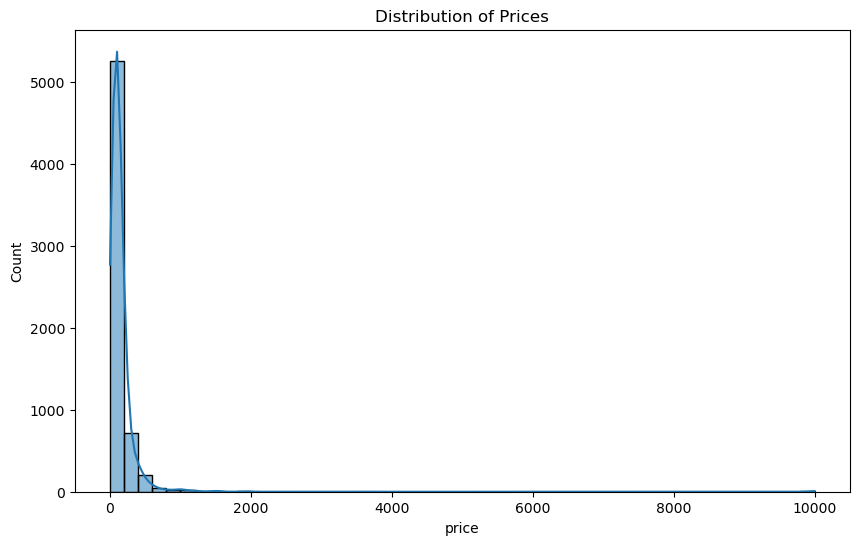

In [18]:
# Plot a histogram to visualize the distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(df_listings['price'], bins=50, kde=True)
plt.title('Distribution of Prices')
plt.show()

From the histogram, we can observe several outliers in the higher price range. To better understand these outliers and determine what trim is necessary, we will examine the descriptive statistics of the price column.

In [19]:
#Descriptive statistics
df_listings['price'].describe()

count     6292.000000
mean       152.616179
std        369.210746
min          0.000000
25%         64.000000
50%         99.000000
75%        155.000000
max      10000.000000
Name: price, dtype: float64

Given the significantly high standard deviation, a minimum value of 0, and a maximum value of 10,000 in the price column, we indeed have outliers. Additionally, with the 75th percentile value of the data being priced at 155 or lower, it suggests that most of the listings are priced much lower than outliers. 

We will proceed to trim our values above a certain treshold, in this case we will do three times the 75th percentile (465).


In [20]:
#Filter the dataset to find Airbnbs with price greater than 465
expensive_airbnbs = df[df['price'] > 465]

#Count how many Airbnbs are more expensive than 465
num_expensive_airbnbs = expensive_airbnbs.shape[0]

num_expensive_airbnbs

207

We will be trimming 203 outliers from the dataset. After performing the trim, we will create a new histogram to visualize the distribution of the cleaned data. This will allow us to asses if the trimming has improved the data's distribution.

In [21]:
#Remove outliers from price column
df_listings = df_listings[(df_listings['price']< 465)]

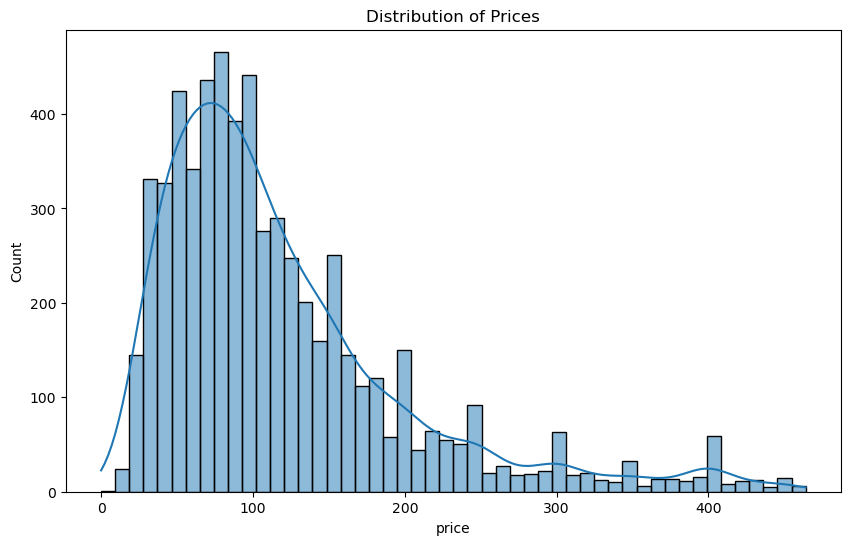

In [22]:
# Plot a histogram to visualize the distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(df_listings['price'], bins=50, kde=True)
plt.title('Distribution of Prices')
plt.show()

In [23]:
#Descriptive statistics
df_listings['price'].describe()

count    6085.000000
mean      118.809367
std        82.714387
min         0.000000
25%        62.000000
50%        97.000000
75%       150.000000
max       464.000000
Name: price, dtype: float64

The standard deviation reduced more than 50%. 

In [24]:
#Looking at the data shape
df_listings.shape

(6085, 10)

In [25]:
df_listings

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Hyde Park,41.787900,-87.587800,Private room,60,2,178,2.56,1,353
1,South Lawndale,41.854950,-87.696960,Entire home/apt,105,2,395,2.81,1,155
2,West Town,41.902890,-87.681820,Entire home/apt,60,2,384,2.81,1,321
3,Lincoln Park,41.917690,-87.637880,Entire home/apt,65,4,49,0.63,9,300
4,Hyde Park,41.796120,-87.592610,Private room,21,1,44,0.61,5,168
...,...,...,...,...,...,...,...,...,...,...
6286,West Town,41.907022,-87.667942,Entire home/apt,344,1,0,0.00,6,355
6287,Near South Side,41.855740,-87.625070,Entire home/apt,146,2,0,0.00,4,180
6288,Near South Side,41.855610,-87.623420,Entire home/apt,195,2,0,0.00,4,180
6290,West Town,41.890050,-87.666680,Private room,53,32,0,0.00,1,83


## Part 5 - Feature Engineering and Final Prep

### Feature engineering

Our first engineering feature is price per night, wich we will calculate by multiplying the price column by the availability_365 column. This feature will provide insights into the potential revenue that can be generated by each airbnb listing throughout a year.

In [26]:
#Creating a feature price per night
df_listings['price_per_year'] = df_listings['price']*df_listings['availability_365']
df_listings.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_per_year
0,Hyde Park,41.78790,-87.58780,Private room,60,2,178,2.56,1,353,21180
1,South Lawndale,41.85495,-87.69696,Entire home/apt,105,2,395,2.81,1,155,16275
2,West Town,41.90289,-87.68182,Entire home/apt,60,2,384,2.81,1,321,19260
3,Lincoln Park,41.91769,-87.63788,Entire home/apt,65,4,49,0.63,9,300,19500
4,Hyde Park,41.79612,-87.59261,Private room,21,1,44,0.61,5,168,3528


Text(0.5, 1.0, 'Bar plot of Room_type for price_per_year')

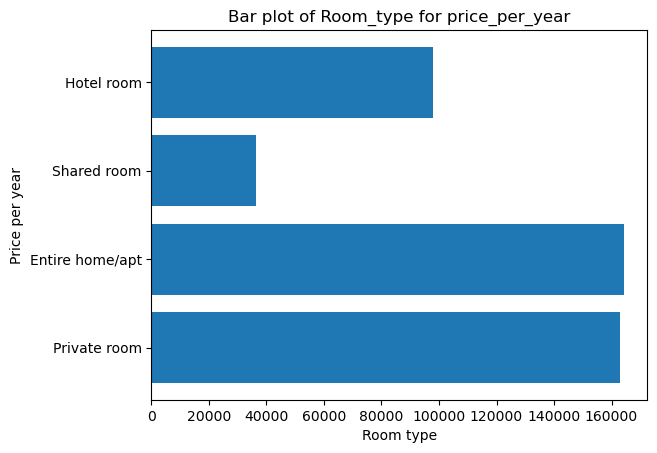

In [27]:
#Creating a bar plot
plt.barh(df_listings['room_type'], df_listings['price_per_year'])

plt.xlabel('Room type')
plt.ylabel('Price per year')
plt.title('Bar plot of Room_type for price_per_year')

The second engineering feature is distance_to_city_center, which calculates the distance from the Airbnb listing to the city center of Chicago. Using the city's latitude and longitude as a reference. 

In [28]:
#Creating a 'distance_to_city_center' feature (Using Chicago city center latitude, longitude)
city_center = (41.8781, -87.6298) 
df_listings['distance_to_city_center'] = df_listings.apply(lambda row: geodesic((row['latitude'], row['longitude']), city_center).km, axis=1)

df_listings.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_per_year,distance_to_city_center
0,Hyde Park,41.78790,-87.58780,Private room,60,2,178,2.56,1,353,21180,10.608606
1,South Lawndale,41.85495,-87.69696,Entire home/apt,105,2,395,2.81,1,155,16275,6.140182
2,West Town,41.90289,-87.68182,Entire home/apt,60,2,384,2.81,1,321,19260,5.120586
3,Lincoln Park,41.91769,-87.63788,Entire home/apt,65,4,49,0.63,9,300,19500,4.448138
4,Hyde Park,41.79612,-87.59261,Private room,21,1,44,0.61,5,168,3528,9.615247


### Encoding categorical 

To finalize our data cleaning process we will encode the two categorical columns, neighbourhood and room_type.

In [29]:
df_encoded = pd.get_dummies(df_listings, columns=['neighbourhood', 'room_type'])
df_encoded.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_per_year,distance_to_city_center,...,neighbourhood_West Garfield Park,neighbourhood_West Lawn,neighbourhood_West Pullman,neighbourhood_West Ridge,neighbourhood_West Town,neighbourhood_Woodlawn,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,41.78790,-87.58780,60,2,178,2.56,1,353,21180,10.608606,...,False,False,False,False,False,False,False,False,True,False
1,41.85495,-87.69696,105,2,395,2.81,1,155,16275,6.140182,...,False,False,False,False,False,False,True,False,False,False
2,41.90289,-87.68182,60,2,384,2.81,1,321,19260,5.120586,...,False,False,False,False,True,False,True,False,False,False
3,41.91769,-87.63788,65,4,49,0.63,9,300,19500,4.448138,...,False,False,False,False,False,False,True,False,False,False
4,41.79612,-87.59261,21,1,44,0.61,5,168,3528,9.615247,...,False,False,False,False,False,False,False,False,True,False


## Part 6 – Constructing an Optimal Model

After cleaning the data, We will proceed to create a RandomForestRegressor model with a three-way split.

In [30]:
#Splitting the data into X and y
X = df_encoded.drop(columns=['price_per_year'])
y = df_encoded['price_per_year'] 

We wil create the initial split in the dataset by using 70% of the data for our training set. The remaining 30% will be temporarily held aside as X_temp and y_temp.

In [31]:
#Train-Validation-Test Split - First split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state=42, test_size=0.3)

We will look at the data to verify the split.

In [32]:
#Checking the data
X_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1826 entries, 3568 to 4716
Data columns (total 89 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   latitude                              1826 non-null   float64
 1   longitude                             1826 non-null   float64
 2   price                                 1826 non-null   int64  
 3   minimum_nights                        1826 non-null   int64  
 4   number_of_reviews                     1826 non-null   int64  
 5   reviews_per_month                     1826 non-null   float64
 6   calculated_host_listings_count        1826 non-null   int64  
 7   availability_365                      1826 non-null   int64  
 8   distance_to_city_center               1826 non-null   float64
 9   neighbourhood_Albany Park             1826 non-null   bool   
 10  neighbourhood_Archer Heights          1826 non-null   bool   
 11  neighbourhood_Armou

In [33]:
#Checking y_temp data
y_temp.head()

3568        0
303     48024
3404        0
260     21980
985     26128
Name: price_per_year, dtype: int64

Now, 30% of our data will be divided into a validation set and test set by 50% of that 30%. This means the validation set and the test set will each account for 15% of the total.

In [34]:
# Train-Validation-Test Split - Second split
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, random_state=42, test_size=0.5)

Looking at X_test and X_val data to ensure the data was split 50% each.

In [35]:
print(X_test.shape)
X_test.head()

(913, 89)


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance_to_city_center,neighbourhood_Albany Park,...,neighbourhood_West Garfield Park,neighbourhood_West Lawn,neighbourhood_West Pullman,neighbourhood_West Ridge,neighbourhood_West Town,neighbourhood_Woodlawn,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
3605,41.88302,-87.63417,116,30,1,0.07,205,340,0.655900,False,...,False,False,False,False,False,False,True,False,False,False
1802,41.88945,-87.63357,183,30,0,0.00,31,90,1.298911,False,...,False,False,False,False,False,False,True,False,False,False
2931,41.89263,-87.62618,31,4,450,18.91,24,331,1.641593,False,...,False,False,False,False,False,False,False,True,False,False
4751,41.88196,-87.68200,76,2,10,1.57,1,41,4.354083,False,...,False,False,False,False,False,False,True,False,False,False
1198,42.01219,-87.66929,176,2,164,3.46,1,5,15.249407,False,...,False,False,False,False,False,False,True,False,False,False


In [36]:
print(X_val.shape)
X_val.head()

(913, 89)


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance_to_city_center,neighbourhood_Albany Park,...,neighbourhood_West Garfield Park,neighbourhood_West Lawn,neighbourhood_West Pullman,neighbourhood_West Ridge,neighbourhood_West Town,neighbourhood_Woodlawn,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
3920,41.88929,-87.63049,99,1,99,6.48,8,362,1.244204,False,...,False,False,False,False,False,False,False,False,True,False
5024,41.89330,-87.61830,48,25,0,0.00,14,0,1.939416,False,...,False,False,False,False,False,False,False,False,True,False
2150,41.91391,-87.72853,80,2,9,0.32,2,262,9.107583,False,...,False,False,False,False,False,False,True,False,False,False
4641,41.89313,-87.65992,92,2,5,0.45,4,45,3.006083,False,...,False,False,False,False,True,False,False,False,True,False
2752,41.99579,-87.76772,85,2,17,0.69,4,0,17.369740,False,...,False,False,False,False,False,False,True,False,False,False


X_test was split in 933 and X_val was split at 933. It is close to 50% each.

In [37]:
print(y_test.shape)
y_test.head()

(913,)


3605    39440
1802    16470
2931    10261
4751     3116
1198      880
Name: price_per_year, dtype: int64

In [38]:
print(y_val.shape)
y_val.head()

(913,)


3920    35838
5024        0
2150    20960
4641     4140
2752        0
Name: price_per_year, dtype: int64

We will proceed to train the model

In [39]:
#Training the model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [40]:
#Predicting on test data
y_pred = model.predict(X_test)

In [41]:
#Evaluating the model
mse = mean_squared_error(y_test, y_pred)  
r2 = r2_score(y_test, y_pred)

In [42]:
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 705622.138296495
R-squared: 0.9987878041511091


Our R-squared value is strong at 0.99, however the MSE is significantly higher at 711414.66 indicating that the model's predictions are far from the actual values, the model is not performing well in terms of accuracy. We will examine the feature importances to gain further insights.

In [43]:
#Naming the features
features_names = ['neighbourhood','latitude','longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',	'calculated_host_listings_count', 'availability_365', 'price_per_year', 'distance_to_city_center']

In [44]:
#Creating a dataframe
X_df = pd.DataFrame(X, columns = features_names)

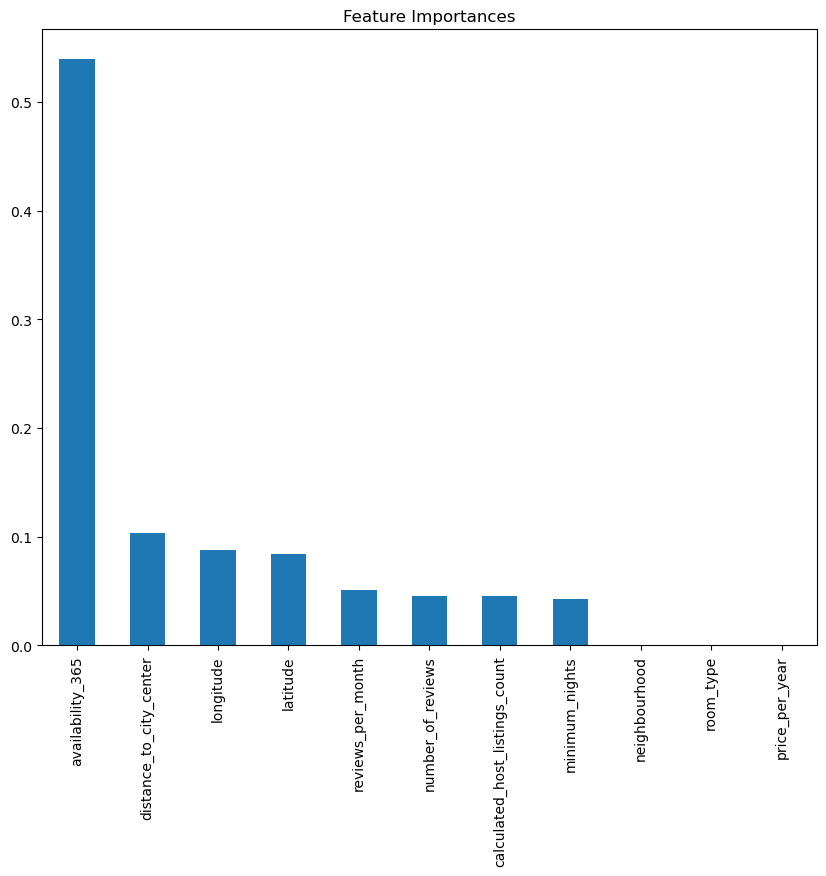

In [45]:
#Running feature importance with Random Forest Regressor
rf =RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_df, y)
feat_importances = pd.Series(rf.feature_importances_, index= X_df.columns)
feat_importances = feat_importances.sort_values(ascending=False)
feat_importances.plot(kind ='bar', figsize=(10,8), title='Feature Importances')
plt.show()

To optimize the model, we will create a new feature price_vs_neighbourhood_avg, this will allow us to understand if price is dependent on neighbourhood.

We will proceed to create a copy from our dataset.

In [46]:
df_listings_ideal = df_listings.copy()

Price_vs_neighbourhood_avg will be created as an engineering feature, which will be calculated by computing the average price per neighborhood. This feature will allow us to compare the price of a listing to the neighborhood average. 

Since our analysis focuses on deciding whether to purchase a property, this feature will provide valuable insights. Therefore, we will use it as the target variable in our model. 

In [47]:
# Calculate the average price per neighborhood
neighbourhood_avg_price = df_listings_ideal.groupby('neighbourhood')['price'].transform('mean')

# Create a new feature 'price_vs_neighborhood_avg'
df_listings_ideal['price_vs_neighbourhood_avg'] = df_listings_ideal['price'] / neighbourhood_avg_price

df_listings_ideal.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_per_year,distance_to_city_center,price_vs_neighbourhood_avg
0,Hyde Park,41.78790,-87.58780,Private room,60,2,178,2.56,1,353,21180,10.608606,0.715026
1,South Lawndale,41.85495,-87.69696,Entire home/apt,105,2,395,2.81,1,155,16275,6.140182,1.520664
2,West Town,41.90289,-87.68182,Entire home/apt,60,2,384,2.81,1,321,19260,5.120586,0.475569
3,Lincoln Park,41.91769,-87.63788,Entire home/apt,65,4,49,0.63,9,300,19500,4.448138,0.435831
4,Hyde Park,41.79612,-87.59261,Private room,21,1,44,0.61,5,168,3528,9.615247,0.250259


We will look at descriptive statistics for the whole dataset and look at the standard deviation per column.

In [48]:
df_listings_ideal.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_per_year,distance_to_city_center,price_vs_neighbourhood_avg
count,6085.000000,6085.000000,6085.000000,6085.00000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000
mean,41.898735,-87.664049,118.809367,8.20378,43.663599,1.464539,13.822679,173.271487,21307.576993,7.075302,1.000000
std,0.059432,0.042595,82.714387,23.07321,68.075016,1.735546,37.542152,138.846267,25533.975918,4.396842,0.654591
min,41.647360,-87.846810,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.060568,0.000000
25%,41.871950,-87.687780,62.000000,1.00000,2.000000,0.150000,1.000000,34.000000,2520.000000,3.420244,0.574713
50%,41.901620,-87.661100,97.000000,2.00000,16.000000,0.880000,2.000000,159.000000,12496.000000,6.595052,0.823471
75%,41.939930,-87.632960,150.000000,3.00000,57.000000,2.260000,7.000000,327.000000,31584.000000,9.969559,1.205266
max,42.022510,-87.537520,464.000000,500.00000,632.000000,32.430000,205.000000,365.000000,164250.000000,26.207479,5.063291


Price column has a higher standard deviation and it is prompting price_per_year to also exhibit a higher standard deviation. We will examine their distributions to gain further insight.

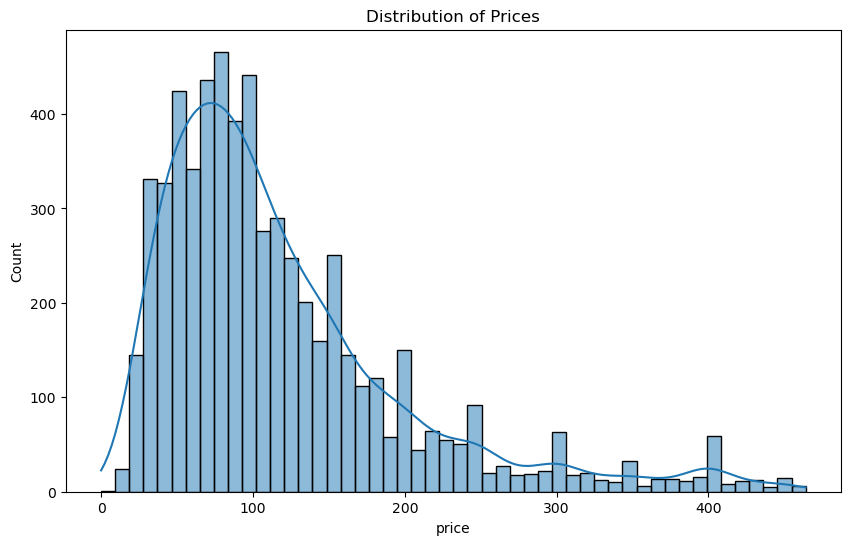

In [49]:
# Plot a histogram to visualize the distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(df_listings_ideal['price'], bins=50, kde=True)
plt.title('Distribution of Prices')
plt.show()

The distribution seems to have 0 price values, those values won't give valuable information to our analysis so we will trim it.

In [50]:
#Remove outliers from price column
df_listings_ideal = df_listings_ideal[(df_listings_ideal['price']>0)]

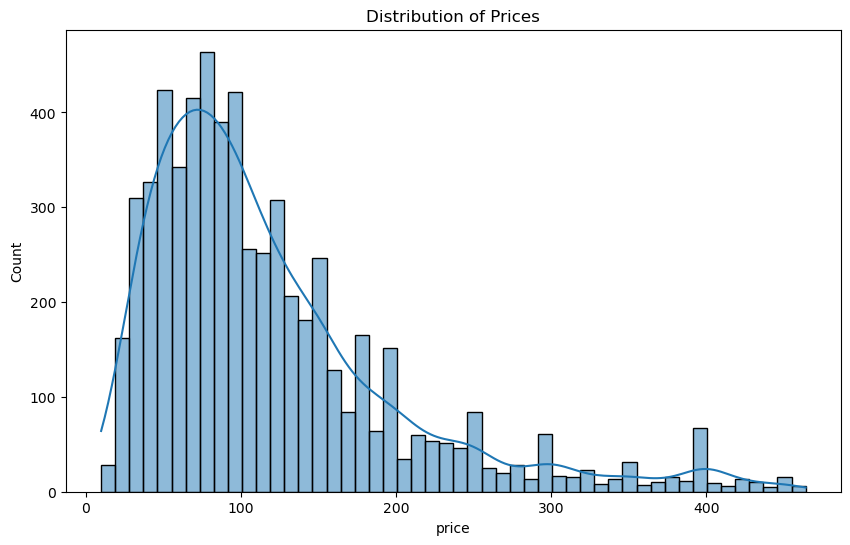

In [51]:
# Plot a histogram to visualize the distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(df_listings_ideal['price'], bins=50, kde=True)
plt.title('Distribution of Prices')
plt.show()

In [52]:
df_listings_ideal = df_listings_ideal.drop(columns=['neighbourhood'])
df_listings_ideal

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_per_year,distance_to_city_center,price_vs_neighbourhood_avg
0,41.787900,-87.587800,Private room,60,2,178,2.56,1,353,21180,10.608606,0.715026
1,41.854950,-87.696960,Entire home/apt,105,2,395,2.81,1,155,16275,6.140182,1.520664
2,41.902890,-87.681820,Entire home/apt,60,2,384,2.81,1,321,19260,5.120586,0.475569
3,41.917690,-87.637880,Entire home/apt,65,4,49,0.63,9,300,19500,4.448138,0.435831
4,41.796120,-87.592610,Private room,21,1,44,0.61,5,168,3528,9.615247,0.250259
...,...,...,...,...,...,...,...,...,...,...,...,...
6286,41.907022,-87.667942,Entire home/apt,344,1,0,0.00,6,355,122120,4.509932,2.726595
6287,41.855740,-87.625070,Entire home/apt,146,2,0,0.00,4,180,26280,2.514396,1.092971
6288,41.855610,-87.623420,Entire home/apt,195,2,0,0.00,4,180,35100,2.553522,1.459790
6290,41.890050,-87.666680,Private room,53,32,0,0.00,1,83,4399,3.336451,0.420086


In [53]:
#Encoding neighbourhood and room_type data
df_encoded1 = pd.get_dummies(df_listings_ideal, columns=['room_type'])
df_encoded1.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_per_year,distance_to_city_center,price_vs_neighbourhood_avg,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,41.78790,-87.58780,60,2,178,2.56,1,353,21180,10.608606,0.715026,False,False,True,False
1,41.85495,-87.69696,105,2,395,2.81,1,155,16275,6.140182,1.520664,True,False,False,False
2,41.90289,-87.68182,60,2,384,2.81,1,321,19260,5.120586,0.475569,True,False,False,False
3,41.91769,-87.63788,65,4,49,0.63,9,300,19500,4.448138,0.435831,True,False,False,False
4,41.79612,-87.59261,21,1,44,0.61,5,168,3528,9.615247,0.250259,False,False,True,False


In [54]:
df_encoded1

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price_per_year,distance_to_city_center,price_vs_neighbourhood_avg,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,41.787900,-87.587800,60,2,178,2.56,1,353,21180,10.608606,0.715026,False,False,True,False
1,41.854950,-87.696960,105,2,395,2.81,1,155,16275,6.140182,1.520664,True,False,False,False
2,41.902890,-87.681820,60,2,384,2.81,1,321,19260,5.120586,0.475569,True,False,False,False
3,41.917690,-87.637880,65,4,49,0.63,9,300,19500,4.448138,0.435831,True,False,False,False
4,41.796120,-87.592610,21,1,44,0.61,5,168,3528,9.615247,0.250259,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6286,41.907022,-87.667942,344,1,0,0.00,6,355,122120,4.509932,2.726595,True,False,False,False
6287,41.855740,-87.625070,146,2,0,0.00,4,180,26280,2.514396,1.092971,True,False,False,False
6288,41.855610,-87.623420,195,2,0,0.00,4,180,35100,2.553522,1.459790,True,False,False,False
6290,41.890050,-87.666680,53,32,0,0.00,1,83,4399,3.336451,0.420086,False,False,True,False


Now, we will run our model 

In [55]:
#Splitting the data into X and y
X = df_encoded1.drop(columns=['price_vs_neighbourhood_avg'])
y = df_encoded1['price_vs_neighbourhood_avg']

We will create the initial split in the dataset by using 70% of the data for our training set. The remaining 30% will be temporarily held aside as X_temp and y_temp.

In [56]:
#Train-Validation-Test Split - First split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state=42, test_size=0.3)

Now, 30% of our data will be divided into a validation set and test set by 50% of that 30%. This means the validation set and the test set will each account for 15% of the total.

In [57]:
# Train-Validation-Test Split - Second split
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, random_state=42, test_size=0.5)

Running the model with our new target

In [58]:
#Training the model
model2 = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model2.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [59]:
#Predicting on test data
y_pred = model2.predict(X_test)

In [60]:
#Evaluating the model
mse = mean_squared_error(y_test, y_pred)  
r2 = r2_score(y_test, y_pred)

In [61]:
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.014342359212498918
R-squared: 0.9666003135984312


The model performance has improved with our new target, with a lowe MSE at 0.0123, indicating a better model performance, showing prediction closer to the actual values. And the R-suqared at 0.9691 means that the variance in the target variable is explained by the model, which is a very strong fit.

We would like to know the feature importance for the price_vs_neighborhoud_average.

In [62]:
features_names = ['neighbourhood','latitude','longitude', 'price', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',	'calculated_host_listings_count', 'availability_365', 'price_per_year', 'distance_to_city_center']

In [63]:
#Creating a dataframe
X_df = pd.DataFrame(X, columns = features_names)

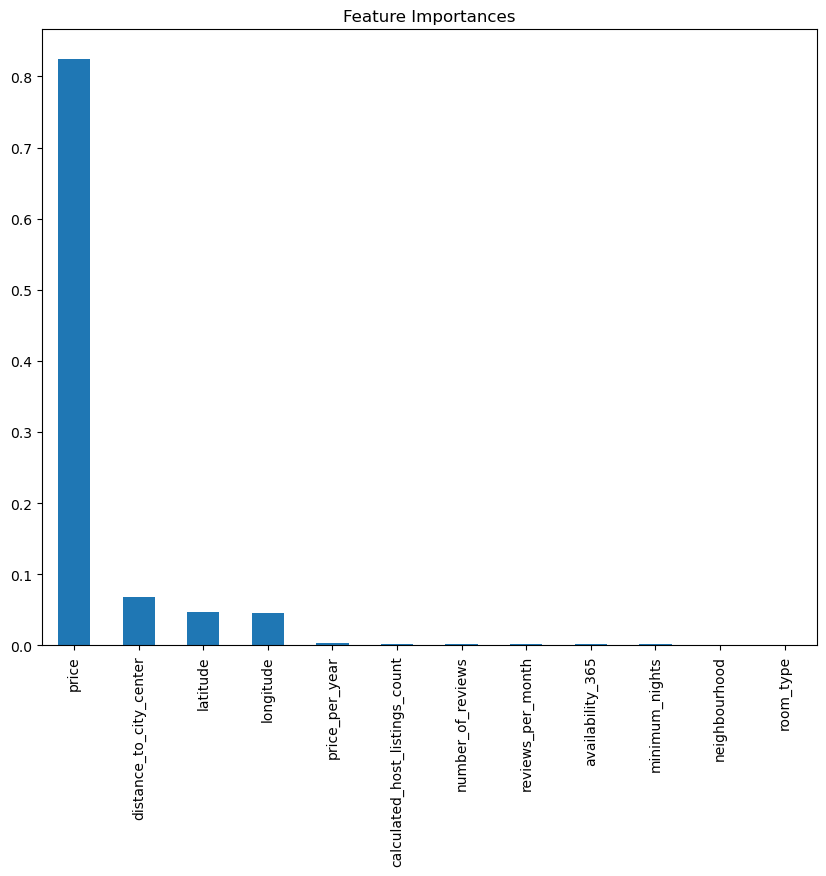

In [64]:
#Running feature importance with Random Forest Regressor
rf =RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_df, y)
feat_importances = pd.Series(rf.feature_importances_, index= X_df.columns)
feat_importances = feat_importances.sort_values(ascending=False)
feat_importances.plot(kind ='bar', figsize=(10,8), title='Feature Importances')
plt.show()

Aribnb price is showing as the most important feature, giving us an insight that based on the location of the airbnb it will be the price per night.

We would like to look closely to the other features so we will drop price in the next feature importance analysis.

In [65]:
features_names = ['neighbourhood','latitude','longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',	'calculated_host_listings_count', 'availability_365', 'price_per_year', 'distance_to_city_center']

In [66]:
#Creating a dataframe
X_df = pd.DataFrame(X, columns = features_names)

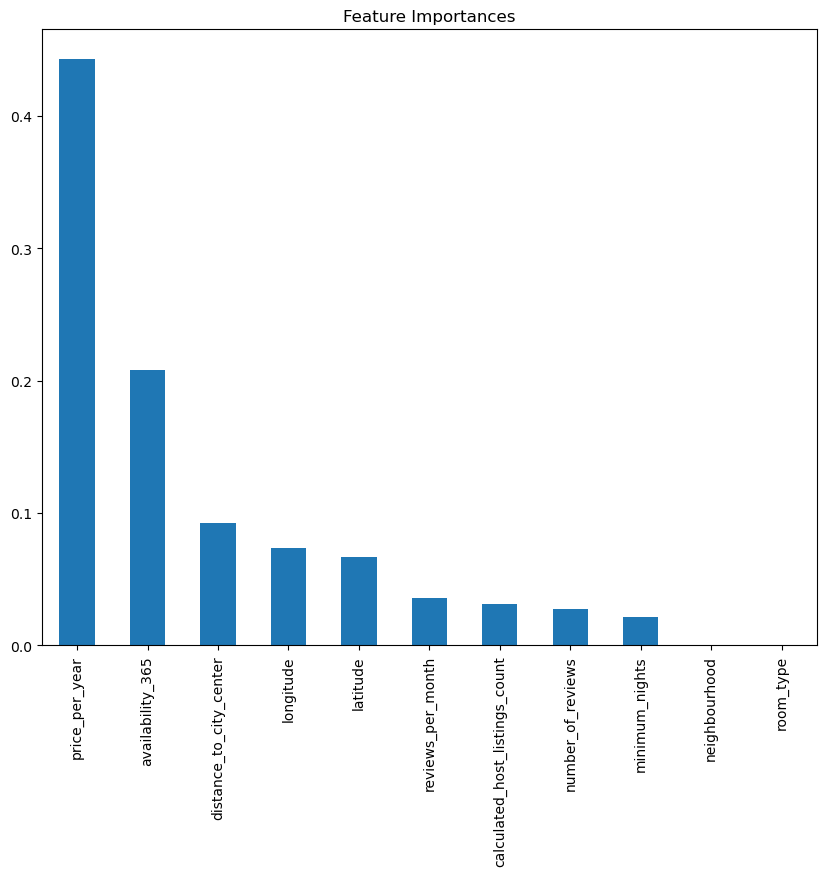

In [67]:
#Running feature importance with Random Forest Regressor
rf =RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_df, y)
feat_importances = pd.Series(rf.feature_importances_, index= X_df.columns)
feat_importances = feat_importances.sort_values(ascending=False)
feat_importances.plot(kind ='bar', figsize=(10,8), title='Feature Importances')
plt.show()

The five most important features (including price) are price_per_year, availability_365, room_type, and distance_to_city_center.

### Saving the Optimal Model

In [68]:
# Save the model using joblib
model_filename = "iris_rf_model.joblib"
joblib.dump(model2, model_filename)

['iris_rf_model.joblib']